In [524]:
#python deep_dream.py path_to_your_base_image.jpg prefix_for_results
#python deep_dream.py img/mypic.jpg results/dream

from __future__ import print_function

from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K
from keras.preprocessing import image
import keras


import tensorflow as tf
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model



In [405]:
K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet',include_top=False)
dream = model.input
print('Model loaded.')

Model loaded.


In [451]:
import os
import cav
working_dir = '/home/tyler/Desktop/tcav_on_azure'

concept = 'striped_sub_1'

cav_dict = {}
layer_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']
for layer_name in layer_names:
    subpath = concept + '-random500_0-' + layer_name
    cav_path = 'cavs/' + subpath + '-linear-0.1.pkl'
    path = os.path.join(working_dir, cav_path)
    this_cav = cav.CAV.load_cav(path)
    cav_dict[layer_name] = this_cav.cavs[0]

In [419]:
#cav_dict

In [499]:
step = 0.05  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 10  # Number of ascent steps per scale
max_loss = 100000000000

#base_image_path = '/home/tyler/Desktop/tcav_on_azure/concepts/horse_sub_1/img103.jpg'
base_image_path = '/home/tyler/Desktop/tcav_on_azure/concepts/noise_white/img1.jpg'

#result_prefix = '/home/tyler/Desktop/tcav_on_azure/results/test'

settings = {
    'features': {
        'mixed0': 1,
        'mixed1': 1,
        'mixed2': 1,
        'mixed3': 1,
        #'mixed4': 1,
        #'mixed5': 1,
        #'mixed6': 1,
        #'mixed7': 1,
        #'mixed8': 1,
        #'mixed9': 1,
        #'mixed10': 10
    },}

In [486]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

sess = K.get_session()

loss_2 = K.variable(0.)
for layer_name in settings['features']:
    coeff = settings['features'][layer_name]
    
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'

    coeff = settings['features'][layer_name]
    acts = layer_dict[layer_name].output
    flat_acts = K.flatten(acts)
    
    len_of_acts = flat_acts.shape[0]
    print(len_of_acts)
    
    layer_cav = K.variable(cav_dict[layer_name].reshape(-1,1))
    #layer_cav_slice = K.slice(layer_cav,0,flat_acts.shape[0])
    n = layer_cav.shape[0]
    print(n, layer_name)
    n_tensor = K.constant(n.value/1000)
    
    features_shape = tf.shape(flat_acts)
    H = features_shape[0]
    #W = features_shape[2]

    #layer_cav_slice = K.reshape(layer_cav, shape=[H,1])
    print(H)
    layer_cav_slice = K.slice(layer_cav,(0,0),(H,1))

    flat_acts_slice = K.reshape(flat_acts, shape=[1,H])
    
    
    print('layer_cav shape is ' + str(layer_cav_slice.shape))
    print('acts shape is ' + str(flat_acts_slice.shape))
    
    #loss_2 += coeff * K.dot(K.reshape(acts,(1,n)),layer_cav)
    loss_2 += coeff * K.dot(flat_acts_slice,layer_cav_slice)
    
    #loss_2 += coeff * eu_distance(acts,layer_cav)
    #loss_2 -= K.sum(K.abs(K.reshape(acts,(n,1))-layer_cav),axis=0,keepdims=False)
    #loss_2 += cosine_distance((flat_acts,layer_cav))
    #loss_2 += K.dot(K.reshape(acts,(1,n)),layer_cav) / n_tensor

    #print(loss_2.shape)

#loss_2 += 1000 * K.sum(K.square(model.input)) / (3 * 299 * 299)

#loss_2 = loss
grads_2 = K.gradients(loss_2, model.input)[0]
grads_2 /= K.maximum(K.mean(K.abs(grads_2)), K.epsilon())

outputs_2 = [loss_2, grads_2, acts]
fetch_loss_and_grads_2 = K.function([model.input], outputs_2)



def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads_2([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        if i % 5 == 0:
            print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

?
352800 mixed1
Tensor("strided_slice_292:0", shape=(), dtype=int32)
layer_cav shape is (?, 1)
acts shape is (1, ?)
?
352800 mixed2
Tensor("strided_slice_293:0", shape=(), dtype=int32)
layer_cav shape is (?, 1)
acts shape is (1, ?)
?
221952 mixed3
Tensor("strided_slice_294:0", shape=(), dtype=int32)
layer_cav shape is (?, 1)
acts shape is (1, ?)
?
313600 mixed0
Tensor("strided_slice_295:0", shape=(), dtype=int32)
layer_cav shape is (?, 1)
acts shape is (1, ?)


## With Scaling

In [500]:
base_image_path = '/home/tyler/Desktop/tcav_on_azure/concepts/horse_sub_1/img233.jpg'
#base_image_path = '/home/tyler/Desktop/tcav_on_azure/concepts/noise_color/img1.jpg'

jitter_setting = .01

In [501]:
tf.logging.set_verbosity(0)

img_pic = image.load_img(base_image_path, target_size=(299, 299))
img = image.img_to_array(img_pic)
img = preprocess_image(base_image_path)
img = resize_img(img,(299,299,3))
#img = np.expand_dims(img, axis=0) / 255

jitter =  2*(np.random.random((img.shape[1], img.shape[2], 3)) - 0.5) * jitter_setting
jitter = np.expand_dims(jitter, axis=0)
img += jitter
    
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    x,y = shape
    if x < 400 and y < 400:
        successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)

    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
img -= jitter
save_img(img, fname='results/test_1.png')

Processing image shape (152, 152)
..Loss value at 0 : [[2846.252]]
..Loss value at 5 : [[16308.868]]
Processing image shape (213, 213)
..Loss value at 0 : [[14127.342]]
..Loss value at 5 : [[48635.83]]
Processing image shape (299, 299)
..Loss value at 0 : [[40186.074]]
..Loss value at 5 : [[121442.97]]


/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:72: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


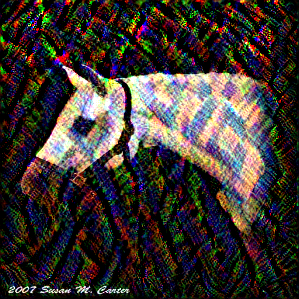

In [502]:
#img_path = 'concepts/striped_sub_1/striped_0004.jpg'
img_path = 'results/test_1.png'
show_img = image.load_img(img_path, target_size=(299, 299))
show_img

In [ ]:
model.

In [529]:
decode_predictions(preds, top=3)

[[('n04507155', 'umbrella', 0.36343685),
  ('n04033995', 'quilt', 0.1369974),
  ('n04275548', 'spider_web', 0.027682718)]]

In [525]:
model = load_model('v3_model.h5')

/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [527]:
#get_prediction(prep(img_path))
preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: prep(img_path)})

In [528]:
preds.shape

(1, 1000)

In [526]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],)

In [514]:
def get_prediction(img):
    img = preprocess_input(img)
    preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})
    top = decode_predictions(preds, top=3)
    return top

def prep(path):
    img_pic = image.load_img(path, target_size=(299, 299))
    img = image.img_to_array(img_pic)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [492]:
#save_img(img, fname='results/zebra/0_1_2_3.png')

In [504]:
#show_img = image.load_img('results/striped_7_8_9.png', target_size=(299, 299))
#show_img

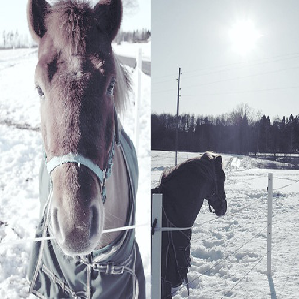

In [364]:
img_pic

In [ ]:
#img_in = image.load_img(base_image_path, target_size=(299, 299))
# 1. run model
# 2. run bottlenecks_tensors
# 3. sess = K.get_session()
img = preprocess_image(base_image_path)
bottleneck_name = 'mixed9'
layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{model.input: img})

In [ ]:
#layer_9_acts.shape

In [ ]:
img.shape

In [ ]:
successive_shapes
img = resize_img(img, shape)

In [ ]:
img.shape

In [ ]:
#img = preprocess_image(base_image_path)
bottleneck_name = 'mixed9'
layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{model.input: img})

In [ ]:
layer_9_acts.shape

In [ ]:
img.shape

In [ ]:
img = gradient_ascent(img,
                      iterations=iterations,
                      step=step,
                      max_loss=max_loss)

In [ ]:
x = img
eval_loss_and_grads(x)

In [ ]:
layer_cav = K.constant(cav_dict[layer_name].reshape(-1,1))
n = layer_cav.shape[0]
print(n, layer_name)
#n_tensor = K.constant(n.value/1000)

coeff = settings['features'][layer_name]
acts = layer_dict[layer_name].output
#flat_acts = K.variable(K.reshape(acts,(1,n)))

#loss_2 += coeff * K.dot(K.reshape(acts,(1,n)),layer_cav) / n_tensor

In [ ]:
acts

In [ ]:
acts_sq = K.squeeze(acts,axis = 1)

In [ ]:
acts_sq

In [ ]:
flat_acts

In [ ]:
layer_cav

In [ ]:
K.slice(acts)

In [ ]:
layer_cav

In [ ]:
layer_dict['mixed9'].output

In [ ]:
cav_dict['mixed9'].shape[0]

In [ ]:
cav_dict['mixed9'].shape[0] / 2048

In [ ]:
x / 288

In [ ]:
model.layers.o

In [ ]:
layer_cav.set_shape(acts.shape)

In [123]:
#image.img_to_array(img_pic)

In [104]:
## No scaling

In [124]:
tf.logging.set_verbosity(0)

base_image_path = 'concepts/striped_sub_1/striped_0004.jpg'
base_image_path = '/home/tyler/Desktop/tcav_on_azure/concepts/noise_white/img1.jpg'

img_pic = image.load_img(base_image_path, target_size=(299, 299))
img = image.img_to_array(img_pic)
img = np.expand_dims(img, axis=0)
img = inception_v3.preprocess_input(img)

jitter =  2*(np.random.random((img.shape[1], img.shape[2], 3)) - 0.5) * .05
jitter = np.expand_dims(jitter, axis=0)
img += jitter

#original_img = np.copy(img)
img = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)

img -= jitter

img_name = 'placeholder'
save_img(img, fname='results/' + img_name + '.png')

..Loss value at 0 : [[-2258.7217]]
..Loss value at 5 : [[32218.432]]
..Loss value at 10 : [[43592.477]]
..Loss value at 15 : [[50999.516]]


/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:72: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [ ]:
    #flat_act = np.reshape(np.asarray(acts).squeeze(), -1)
    #flat_act_norm = keras.utils.normalize(flat_act)
    #loss2 = euclidean_distance(vec_norm(layer_9_cav),flat_act_norm)
    
    #loss_2 += K.sum(K.square(K.reshape(acts,(131072,)) - layer_9_cav_K))
    #loss_2 += K.dot(K.reshape(acts,(1,131072)),K.transpose(layer_9_cav_K))

In [ ]:
layer_name = 'mixed9'
layer_out = layer_dict[layer_name].output

In [ ]:
layer_out

In [ ]:
img_in = shrunk_original_img

In [ ]:
img_in.shape

In [ ]:
new_acts = fetch_loss_and_grads_2([img_in])[0]

In [ ]:
new_acts

In [ ]:
layer_9_acts[0][5][0]

In [ ]:
new_acts[0][5][0]

## New Loss

In [ ]:
def get_loss(this_img):
    layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{endpoints_v3['input']: this_img})
    flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)
    loss += euclidean_distance(vec_norm(layer_9_cav),vec_norm(flat_act))
    
    return loss

In [ ]:
get_loss(original_img)

In [ ]:
original_img.shape

In [ ]:
sess = K.get_session()
#my_graph = tf.get_default_graph()


In [ ]:
#my_graph.get_collection()

In [ ]:
sess

In [ ]:
model.input

In [ ]:
this_img = original_img

loss = K.variable(0.)
layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{model.input: this_img})
flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)
loss += euclidean_distance(vec_norm(layer_9_cav),vec_norm(flat_act))

#K.clear_session()

In [ ]:
layer_9_acts = layer_dict[layer_name].output

In [ ]:
layer_9_acts

In [ ]:
x.shape

In [ ]:
sess.run(bottlenecks_tensors[bottleneck_name],
                         {self.ends['input']: examples})

In [ ]:
#sess.run(bottlenecks_tensors[bottleneck_name],{model.input: img})

In [ ]:
#layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{endpoints_v3['input']: img})

#flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)

In [ ]:
#layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{endpoints_v3['input']: x})

#flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)

#euclidean_distance(vec_norm(layer_9_cav),vec_norm(flat_act))

## Static functions

In [30]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

def euclidean_distance(a,b):
    return np.linalg.norm(a-b)

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)

def get_bottleneck_tensors():
    """Add Inception bottlenecks and their pre-Relu versions to endpoints dict."""
    graph = tf.get_default_graph()
    bn_endpoints = {}
    for op in graph.get_operations():
        # change this below string to change which layers are considered bottlenecks
        # use 'ConcatV2' for InceptionV3
        # use 'MaxPool' for VGG16 (for example)
        if 'ConcatV2' in op.type:
            name = op.name.split('/')[0]
            bn_endpoints[name] = op.outputs[0]

    return bn_endpoints

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

bottlenecks_tensors = get_bottleneck_tensors()
bottleneck_name = 'mixed9'

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def eu_distance(A,B):
    return K.sum(K.abs(A-B),axis=1,keepdims=True)



#Process:
# Load the original image.
# Define a number of processing scales (i.e. image shapes), from smallest to largest.
# Resize the original image to the smallest scale.
# For every scale, starting with the smallest (i.e. current one):
    # Run gradient ascent
    # Upscale image to the next scale
    # Reinject the detail that was lost at upscaling time
# Stop when we are back to the original size.
#To obtain the detail lost during upscaling, we simply take the original image, shrink it down, upscale it,
# and compare the result to the (resized) original image.